In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import netCDF4
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from mne import read_epochs
from hmpai.data import StageFinder, SAT_CLASSES_ACCURACY, SAT_CLASSES_SPEED, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from hmpai.ica import ICA
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "sat2/preprocessed_500hz/S1_epo.fif"
# info_path = DATA_PATH / "sat1/preprocessed/processed_0001_epo.fif"
positions = read_info(info_path)

epoch = read_epochs(info_path)
epoch.set_montage('biosemi64')
positions = epoch.info

Reading /workspace/data_local/sat2/preprocessed_500hz/S1_epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    4000.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
2376 matching events found
No baseline correction applied
0 projection items activated


#### New version (high force)

In [3]:
cpus = 4

epoched_data_path = DATA_PATH / "sat2/data_250hz.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    # fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 1},
    # fit_args={"step": 1, "by_sample": True},
    # fit_args={"by_sample": True},
    # fit_args={"step": 5},
    # fit_args={"diagnostic": True},
    verbose=False,
    condition_variable="condition",
    condition_method="equal",
    # extra_split=[("force", "equal", "high")],
    # fits_to_load=["250hz_accuracy.nc", "250hz_speed.nc"],
    n_comp=10,
    event_width=45,
    behaviour_path=DATA_PATH / "sat2/behavioural/df_full.csv",
)
# Retraining model with smaller window
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Fitting HMP model for accuracy condition
Estimating 4 events model with 1 starting point(s)
parameters estimated for 4 events model
Fitting HMP model for speed condition
Estimating 3 events model with 1 starting point(s)
parameters estimated for 3 events model


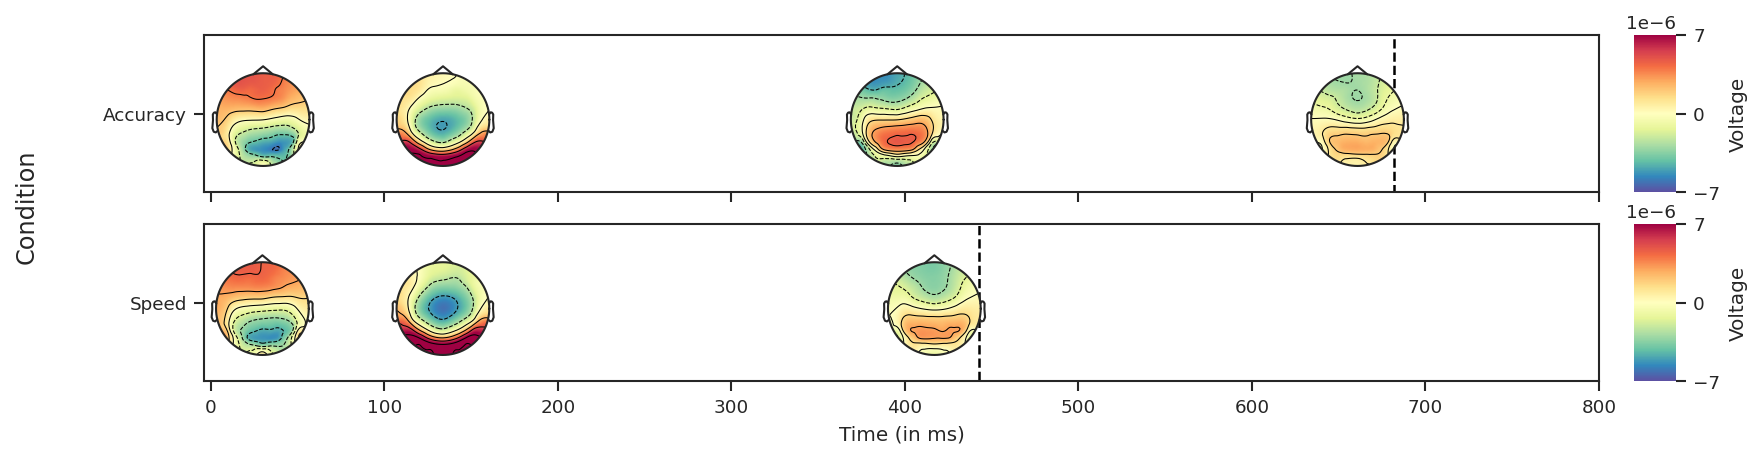

In [4]:
fig, ax = stage_finder.visualize_model(positions, max_time=800, figsize=(12, 3))

In [1]:
import matplotlib.pyplot as plt

fig.savefig("../../img/hmp_fit_test.svg")

NameError: name 'fig' is not defined

In [6]:
hmp.utils.save_fit(stage_finder.fits[0], "250hz_accuracy_45ms.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_speed_45ms.nc")

250hz_accuracy_45ms.nc saved
250hz_speed_45ms.nc saved


In [7]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_45ms.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True)

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S14
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S14
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing particip

In [8]:
stage_data.to_netcdf(output_path)